# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [62]:
import math
import pandas as pd
import networkx as nx
from pyvis.network import Network
from IPython.core.display import display, HTML

C:\Users\fricl\AppData\Local\Temp\ipykernel_28416\816083823.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
#!pip install pyvis
#!pip install jinja2

[Tutorial](https://pyvis.readthedocs.io/en/latest/tutorial.html#getting-started)

In [55]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
articles = country_clicks.index.tolist()
clicks = [f"{country_clicks.click_count.iloc[i]} clicks" for i in range(len(articles))]
clicks

['0 clicks',
 '4 clicks',
 '7 clicks',
 '13 clicks',
 '0 clicks',
 '1 clicks',
 '150 clicks',
 '141 clicks',
 '169 clicks',
 '175 clicks',
 '213 clicks',
 '258 clicks',
 '7 clicks',
 '288 clicks',
 '9 clicks',
 '18 clicks',
 '22 clicks',
 '219 clicks',
 '76 clicks',
 '322 clicks',
 '24 clicks',
 '38 clicks',
 '19 clicks',
 '0 clicks',
 '748 clicks',
 '83 clicks',
 '118 clicks',
 '137 clicks',
 '10 clicks',
 '7 clicks',
 '42 clicks',
 '65 clicks',
 '74 clicks',
 '155 clicks',
 '5 clicks',
 '14 clicks',
 '0 clicks',
 '32 clicks',
 '1048 clicks',
 '193 clicks',
 '64 clicks',
 '66 clicks',
 '43 clicks',
 '12 clicks',
 '24 clicks',
 '14 clicks',
 '9 clicks',
 '14 clicks',
 '5 clicks',
 '85 clicks',
 '42 clicks',
 '36 clicks',
 '9 clicks',
 '22 clicks',
 '8 clicks',
 '10 clicks',
 '144 clicks',
 '14 clicks',
 '126 clicks',
 '97 clicks',
 '97 clicks',
 '16 clicks',
 '125 clicks',
 '0 clicks',
 '14 clicks',
 '33 clicks',
 '27 clicks',
 '0 clicks',
 '72 clicks',
 '8 clicks',
 '2 clicks',
 '33 c

In [64]:
net = Network(directed=True, 
              notebook=True, 
              font_color='#10000000')
net.add_nodes(articles[:1000], 
              title=articles[:1000])

# Let's add edges between articles that are connected in Wikipedia
for i, article1 in enumerate(articles[:1000]):
    print(article1)
    name_links_out = country_clicks.name_links_out.iloc[i]
    print(name_links_out)

    if pd.notna(name_links_out):
        for article2 in articles[:1000]: 
            if article2 in name_links_out:
                print(article2, "is an out link from", article1)
                net.add_edge(article1, article2)
        print("---------")

net.show("graph.html")

%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
['Bede', 'Columba', 'D%C3%A1l_Riata', 'Great_Britain', 'Ireland', 'Isle_of_Man', 'Monarchy', 'Orkney', 'Picts', 'Scotland', 'Wales']
Bede is an out link from %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
Columba is an out link from %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
---------
%C3%85land
['20th_century', 'Baltic_Sea', 'Crimean_War', 'Currency', 'Euro', 'European_Union', 'Finland', 'League_of_Nations', 'List_of_countries_by_system_of_government', 'Nationality', 'Parliamentary_system', 'Police', 'Russia', 'Stockholm', 'Sweden', 'Time_zone', 'Tourism', 'United_Kingdom', 'World_War_II']
20th_century is an out link from %C3%85land
Baltic_Sea is an out link from %C3%85land
---------
%C3%89douard_Manet
['Absinthe', 'Beer', 'Claude_Monet', 'Diego_Vel%C3%A1zquez', 'Edgar_Allan_Poe', 'France', 'Francisco_Goya', 'Germany', 'Impressionism', 'Italy', 'Landscape', 'Netherlands', 'Painting', 'Paris', 'Photography', 'Raphael', 'Renaissance', 'Sweden', 'United_States_dollar', 'Washingt

nx.html


AttributeError: 'NoneType' object has no attribute 'render'

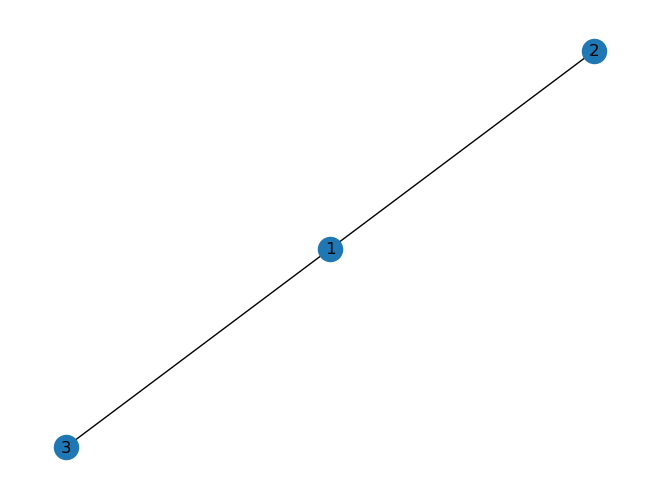

In [ ]:

import networkx as nx

G=nx.Graph()

G.add_edge('1', '2')
G.add_edge('1', '3')

nx.draw(G, with_labels = True)
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show('nx.html')